In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/Users/phaihoang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = "data/redux/"
sz=224
arch=resnet34
bs=16

In [4]:
os.listdir(PATH)

['valid',
 '.DS_Store',
 'test',
 'models',
 'train',
 'tmp',
 'sample_submission.csv']

In [5]:
files = os.listdir(f'{PATH}train')[:5]
files

['dogs', 'cats', '.DS_Store']

In [6]:
img = plt.imread(f'{PATH}train/cats/{files[1]}')
plt.imshow(img)

FileNotFoundError: [Errno 2] No such file or directory: 'data/redux/train/cats/cats'

In [7]:
img.shape

NameError: name 'img' is not defined

In [8]:
img[:4,:4]

NameError: name 'img' is not defined

In [6]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 32/32 [05:11<00:00,  9.74s/it]


In [7]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [8]:
data.classes

['cats', 'dogs']

In [9]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [21]:
log_preds[:10]

array([[ -0.00019,  -8.58465],
       [ -0.0006 ,  -7.4113 ],
       [ -0.46137,  -0.99538],
       [ -0.00001, -11.51162],
       [ -0.00015,  -8.79079],
       [ -0.00004, -10.05562],
       [ -0.00002, -10.77722],
       [ -0.00005,  -9.99458],
       [ -0.00015,  -8.78239],
       [ -0.00119,  -6.73699]], dtype=float32)

In [22]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(arr), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

NameError: name 'arr' is not defined

In [25]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

NameError: name 'arr' is not defined

In [24]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)


Most correct cats


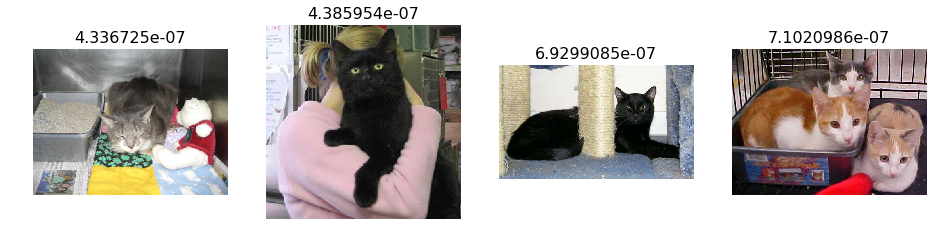

In [26]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


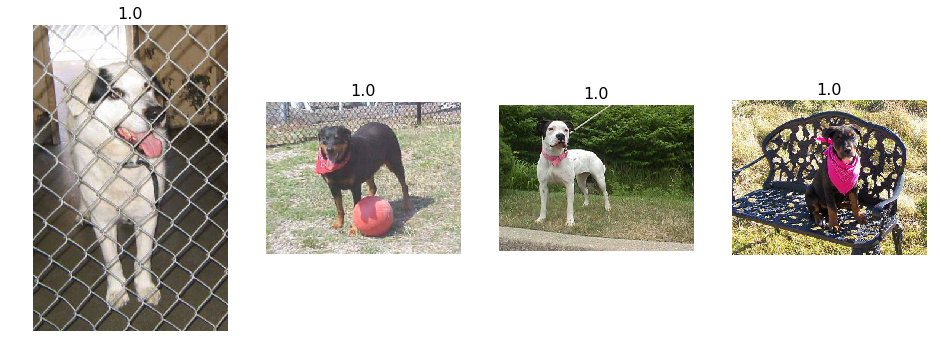

In [27]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


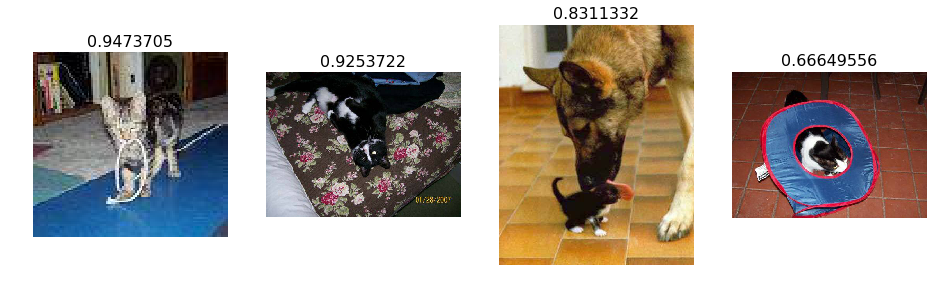

In [28]:
 plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


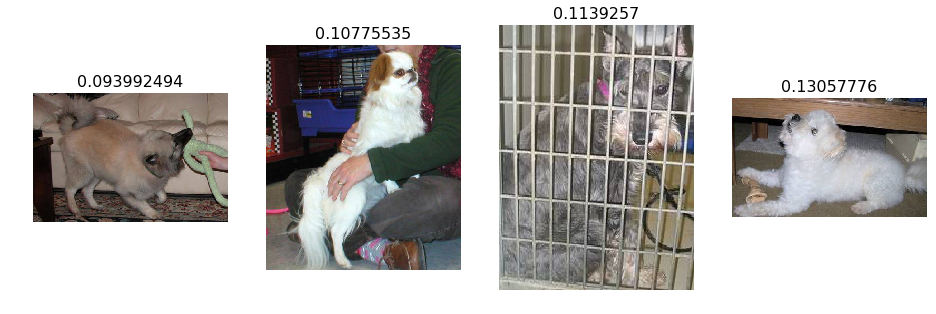

In [29]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


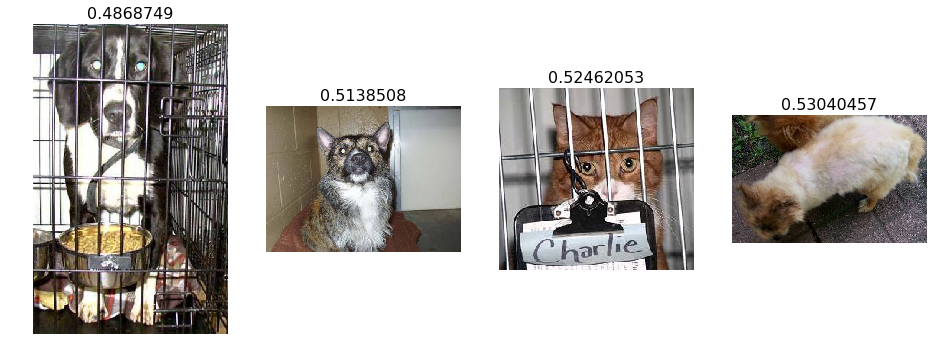

In [30]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [16]:
learn = ConvLearner.pretrained(arch,data, precompute=True) 

learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.055256   0.022385   0.989     
    1      0.040608   0.021788   0.9905                       



[0.02178779925405979, 0.9905]

In [26]:
lrf = learn.lr_find()

 77%|███████▋  | 277/360 [00:05<00:01, 47.88it/s, loss=0.0994]


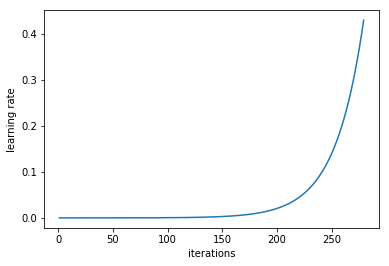

In [24]:
learn.sched.plot_lr()

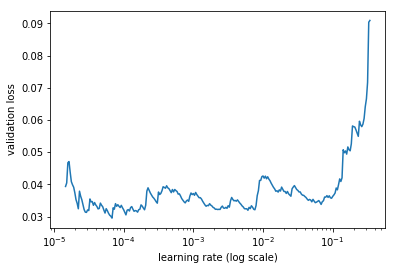

In [25]:
learn.sched.plot()

In [27]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.035568   0.022979   0.9905    



[0.022978802897036077, 0.9905]

In [29]:
learn.precompute=False

In [30]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.039016   0.02281    0.9895    
    1      0.032409   0.022395   0.9895                         
    2      0.03233    0.021946   0.9915                         



[0.021945548877120018, 0.9915]

In [31]:
learn.save('224_lastlayer')

In [32]:
learn.unfreeze()

In [33]:
lr=np.array([1e-4,1e-3,1e-2])

In [36]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                         
    0      0.037342   0.018703   0.993     
    1      0.033649   0.015384   0.994                            
    2      0.020093   0.01565    0.993                            
    3      0.021553   0.016601   0.9935                           
  9%|▊         | 31/360 [12:32<2:13:07, 24.28s/it, loss=0.0178]

KeyboardInterrupt: 